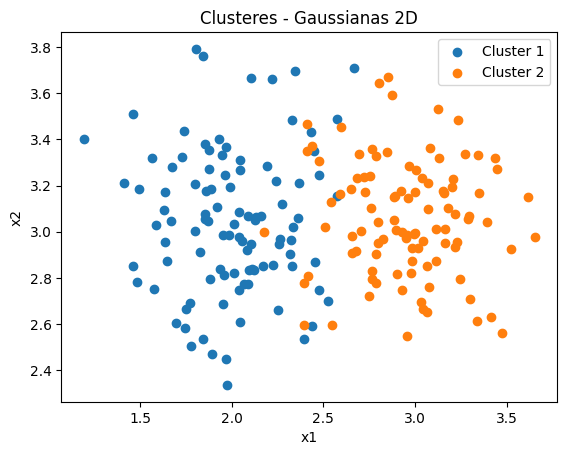

In [12]:
# Gerando os clusteres
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
s1 = 0.3
s2 = 0.3
nc = 100

# Gerador de números aleatórios (opcional: semente para reprodutibilidade)
rng = np.random.default_rng(42)

# Cluster 1 ~ N((2,2), s1^2 I)
#xc1 = rng.normal(size=(nc, 2)) * s1 + np.array([2.0, 2.0])
xc1 = np.random.randn(nc, 2) *  s1 + np.array([2.0, 3.0])
# Cluster 2 ~ N((4,4), s2^2 I)
#xc2 = rng.normal(size=(nc, 2)) * s2 + np.array([4.0, 4.0])
xc2 = np.random.randn(nc, 2) *  s1 + np.array([3.0, 3.0])

# xc1: classe 0, xc2: classe 1
X = np.vstack([xc1, xc2])                 # (N, 2)
y = np.hstack([np.zeros(len(xc1), int),   # 0 para cluster 1
               np.ones(len(xc2), int)])   # 1 para cluster 2

# xc1 e xc2 são arrays (nc x 2) com os pontos
plt.scatter(xc1[:,0], xc1[:,1], label='Cluster 1')
plt.scatter(xc2[:,0], xc2[:,1], label='Cluster 2')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Clusteres - Gaussianas 2D')
plt.show()

In [13]:
def pairwise_sq_dists(A, B):
    """
    Retorna matriz (m x n) com distâncias euclidianas AO QUADRADO
    entre linhas de A (m x d) e B (n x d), sem loops explícitos.
    """
    A2 = np.sum(A*A, axis=1, keepdims=True)     # (m, 1)
    B2 = np.sum(B*B, axis=1, keepdims=True).T   # (1, n)
    return A2 + B2 - 2 * (A @ B.T)

def knn_predict(X_train, y_train, X_query, k):
    """
    Prediz rótulos para X_query usando KNN com:
    - distância euclidiana
    - votação majoritária
    - desempate por menor rótulo
    """
    # 1) todas as distâncias (quadradas) consulta-versus-treino
    D2 = pairwise_sq_dists(X_query, X_train)             # (Q, N)

    # 2) índices dos k menores (sem ordenar toda a linha)
    idx_k = np.argpartition(D2, kth=k-1, axis=1)[:, :k]  # (Q, k)

    # 3) ordena esses k por distância (apenas para estabilidade/visualização)
    rows = np.arange(X_query.shape[0])[:, None]
    order_k = np.argsort(D2[rows, idx_k], axis=1)
    idx_k = idx_k[rows, order_k]                         # (Q, k)

    # 4) rótulos dos vizinhos
    y_neighbors = y_train[idx_k]                         # (Q, k)

    # 5) votação: conta frequência de cada classe entre os k vizinhos
    classes = np.unique(y_train)
    counts = (y_neighbors[..., None] == classes).sum(axis=1)  # (Q, C)

    # 6) vencedor por argmax (empate → menor classe)
    winners = classes[np.argmax(counts, axis=1)]
    return winners


In [14]:
def plot_decision_surface(X, y, predict_fn, k, padding=1.0, step=0.03):
    """
    - Cria um grid que cobre a região dos dados com 'padding'
    - Classifica cada ponto do grid com o KNN
    - Plota a superfície de decisão + dados de treino
    """
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = predict_fn(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    # níveis centrados nas classes inteiras (0.5 separa 0 e 1)
    levels = np.arange(np.max(y) + 2) - 0.5
    plt.contourf(xx, yy, Z, levels=levels, alpha=0.25)

    # pontos de treino
    for cls in np.unique(y):
        mask = (y == cls)
        plt.scatter(X[mask, 0], X[mask, 1], s=30, edgecolors='k', label=f'classe {cls}')

    plt.title(f'KNN — k={k}')
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.legend()
    plt.tight_layout()
    plt.show()


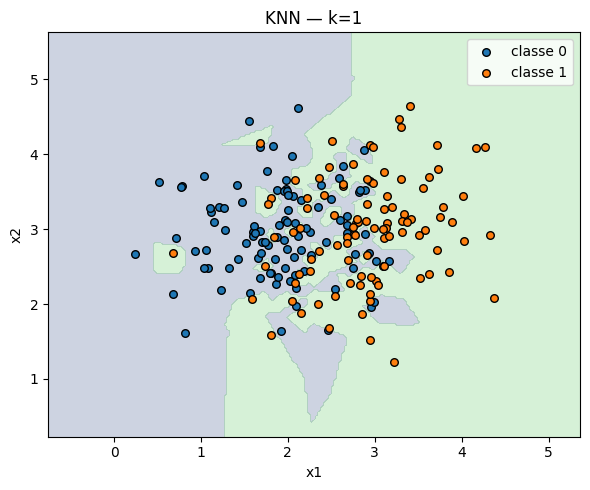

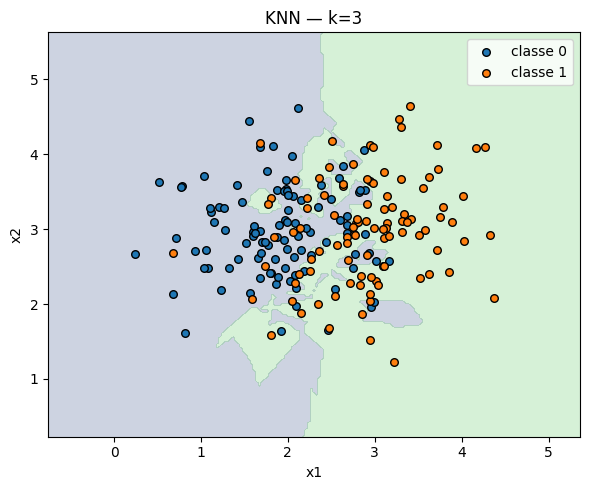

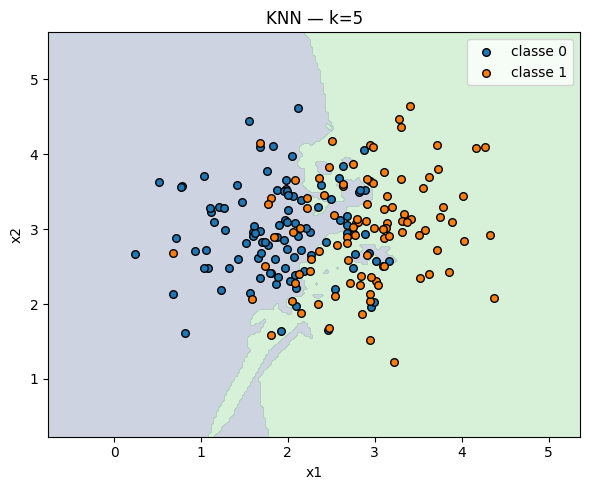

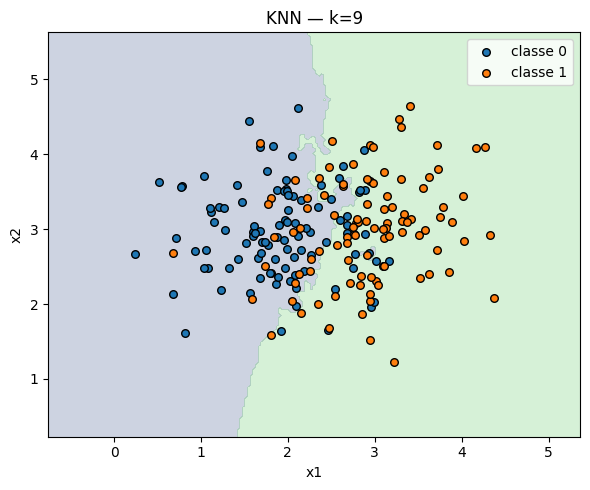

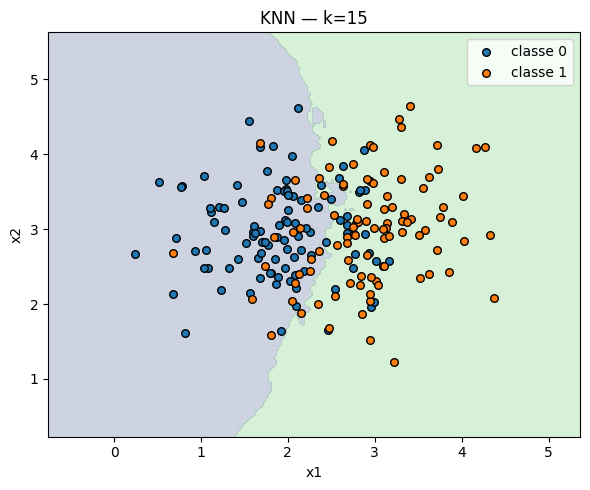

In [18]:
k_values = [1, 3, 5, 9, 15]

for k in k_values:
    predict = lambda Q: knn_predict(X, y, Q, k)
    plot_decision_surface(X, y, predict_fn=predict, k=k)
